In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='dark')
plt.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings("ignore")

import cv2
import tensorflow as tf

from tqdm.auto import tqdm
import shutil

seed = 42
np.random.seed(seed=seed)

In [ ]:
! mkdir -p /root/.kaggle
! mv kaggle.json /root/.kaggle
import kaggle

In [ ]:
! kaggle competitions download -c dogs-vs-cats

 99% 805M/812M [00:05<00:00, 140MB/s]
100% 812M/812M [00:05<00:00, 157MB/s]


In [ ]:
! unzip -q dogs-vs-cats.zip
! unzip -q train.zip

In [ ]:
imgs = os.listdir('train')

paths = []
for img in tqdm(imgs):
  path = os.path.join('train', img)
  paths.append(path)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
def get_label(img):
  label = img[:3]
  return label

In [ ]:
df = pd.DataFrame({'path':paths, 'imgs':imgs})
df['y_true'] = df['imgs'].apply(get_label)
df['result'] = np.nan
df.head()

,path,imgs,y_true,result
0,train/cat.3813.jpg,cat.3813.jpg,cat,NaN
1,train/cat.8154.jpg,cat.8154.jpg,cat,NaN
2,train/cat.4013.jpg,cat.4013.jpg,cat,NaN
3,train/cat.10730.jpg,cat.10730.jpg,cat,NaN
4,train/cat.12268.jpg,cat.12268.jpg,cat,NaN


## Data Pipeline

In [ ]:
# preprocessing
def preprocess(file_path):

  #read img from file path
  byte_img = tf.io.read_file(file_path)
  #decode byte type to jpg
  img = tf.io.decode_jpeg(byte_img)
  #resize
  img = tf.image.resize(img, (224,224))

  return img

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices(df['path'])
test_data = test_data.map(preprocess).batch(128)
test_data = test_data.prefetch(8)
test_itr = iter(test_data)

## Model

In [ ]:
vgg =tf.keras.applications.VGG16()

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
index = 0
for i in tqdm(range(196)):

  test_imgs = test_itr.next()
  preprocessed_img = tf.keras.applications.vgg16.preprocess_input(test_imgs)
  result = vgg.predict(preprocessed_img)
  result = tf.keras.applications.vgg16.decode_predictions(result, top=1)

  idx = len(result) + index
  df.iloc[index:idx, -1] = result
  index = idx

  0%|          | 0/196 [00:00<?, ?it/s]

2/2 [==============================] - 2s 1s/step


## Results

In [ ]:
def get_predictions(result):

  predictions = result[0][1]
  return predictions

def get_probabilities(result):

  probs = result[0][2]
  return probs

In [ ]:
df['predictions'] = df['result'].apply(get_predictions)
df['probs'] = df['result'].apply(get_probabilities)
df.head()

,path,imgs,y_true,result,predictions,probs
0,train/cat.3813.jpg,cat.3813.jpg,cat,"[(n02124075, Egyptian_cat, 0.6304787)]",Egyptian_cat,0.630479
1,train/cat.8154.jpg,cat.8154.jpg,cat,"[(n02124075, Egyptian_cat, 0.52546966)]",Egyptian_cat,0.525470
2,train/cat.4013.jpg,cat.4013.jpg,cat,"[(n02123045, tabby, 0.532662)]",tabby,0.532662
3,train/cat.10730.jpg,cat.10730.jpg,cat,"[(n02124075, Egyptian_cat, 0.34385708)]",Egyptian_cat,0.343857
4,train/cat.12268.jpg,cat.12268.jpg,cat,"[(n02123045, tabby, 0.23215705)]",tabby,0.232157


In [ ]:
df.to_csv("predictions.csv", header=True, index=False)

In [ ]:
len(df.loc[df['y_true']=='cat']['predictions'].value_counts())

363

In [ ]:
len(df.loc[df['y_true']=='dog']['predictions'].value_counts())

311

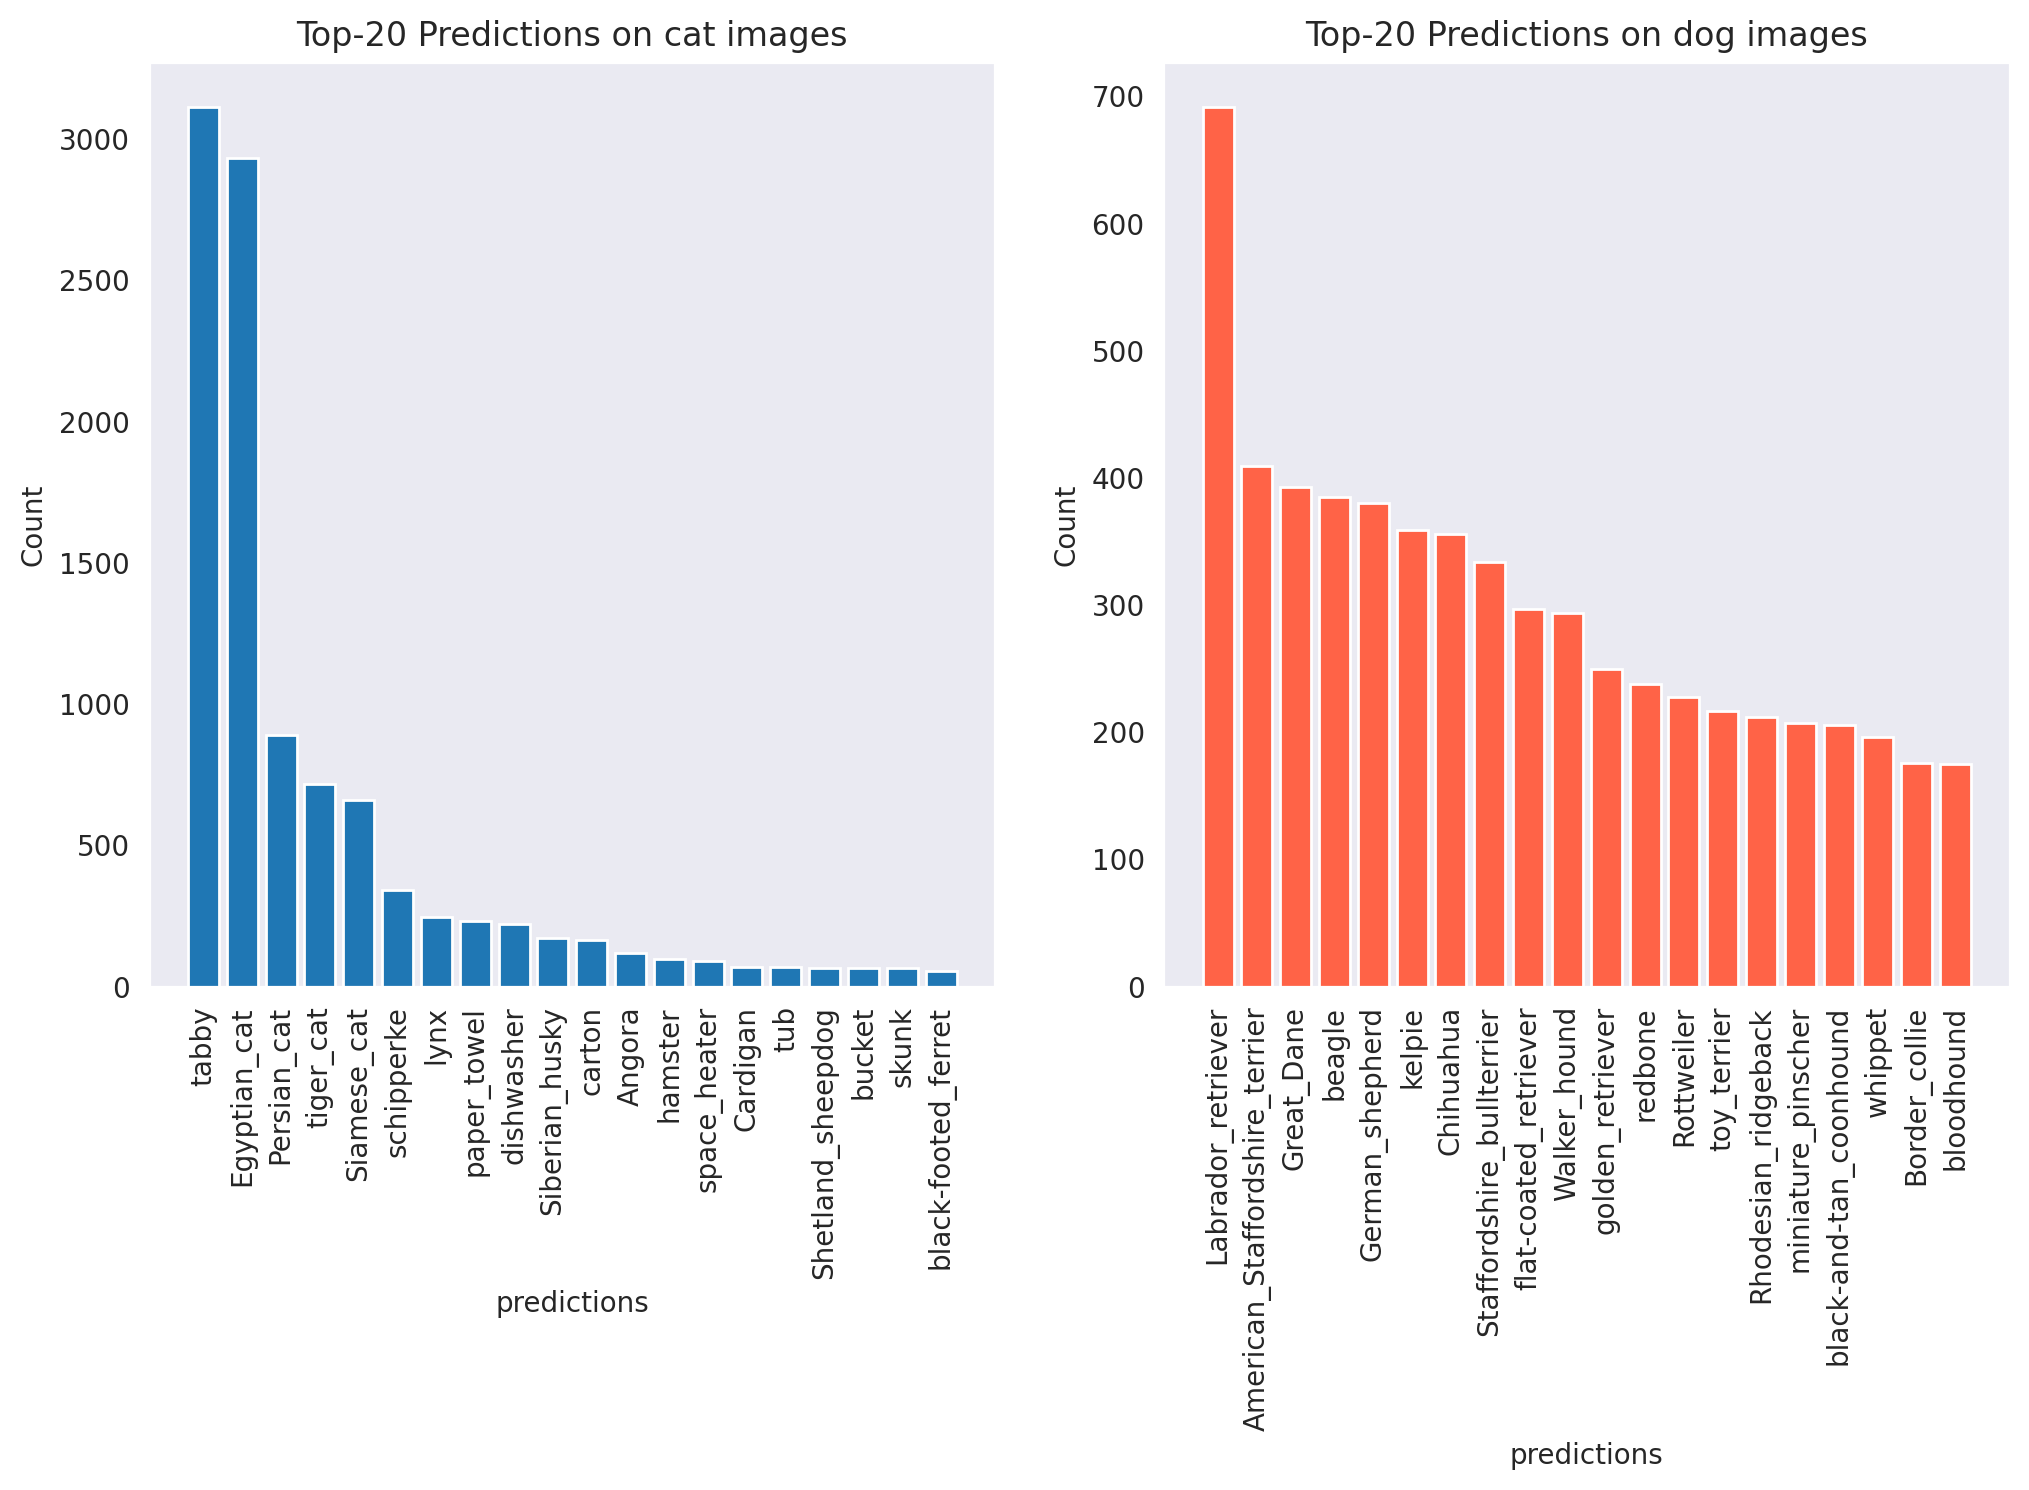

In [ ]:
top_20_cats = df.loc[df['y_true']=='cat']['predictions'].value_counts()[:20]
top_20_dogs = df.loc[df['y_true']=='dog']['predictions'].value_counts()[:20]

plt.subplots(1,2, figsize=(12,6))

plt.subplot(121)
plt.bar(top_20_cats.index, top_20_cats.values)
plt.xticks(rotation=90)
plt.title("Top-20 Predictions on cat images")
plt.xlabel('predictions')
plt.ylabel('Count')

plt.subplot(122)
plt.bar(top_20_dogs.index, top_20_dogs.values, color='tomato')
plt.xticks(rotation=90)
plt.title("Top-20 Predictions on dog images")
plt.xlabel('predictions')
plt.ylabel('Count')
plt.show()